<a href="https://colab.research.google.com/github/shrb2704-del/NOVA.AI/blob/main/NovaAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === Colab Cell 1: Setup & Imports ===
!pip -q install plotly==5.22.0
import os, io, requests, zipfile, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import joblib
# For Colab Drive
from google.colab import drive
drive.mount('/content/drive')
# Where to save model & artifacts
BASE_DIR = "/content/drive/MyDrive/exoplanet_mvp"
os.makedirs(BASE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(BASE_DIR, "rf_koi_model.pkl")
NEW_OBS_CSV = os.path.join(BASE_DIR, "new_observations.csv")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 94.4 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
# === 🚀 Colab Cell 2: Load KOI Data from NASA Exoplanet Archive ===

import io, logging
from google.colab import files

# === 1. Ссылка на официальный датасет NASA (Kepler Q1–Q17 DR25) ===
KOI_URL = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select%20*%20from%20q1_q17_dr25_koi&format=csv"

# === 2. Настройка логов ===
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# === 3. Попытка авто-загрузки ===
try:
    logging.info("🌍 Downloading KOI dataset from NASA Exoplanet Archive...")
    koi_df = pd.read_csv(KOI_URL)
    logging.info(f"✅ Successfully loaded KOI dataset | Shape: {koi_df.shape}")
except Exception as e:
    logging.warning(f"⚠️ Auto-download failed: {e}")
    logging.info("📂 Please upload the KOI dataset manually (CSV file).")
    uploaded = files.upload()
    fname = list(uploaded.keys())[0]
    koi_df = pd.read_csv(io.BytesIO(uploaded[fname]))
    logging.info(f"✅ Successfully loaded uploaded KOI dataset | Shape: {koi_df.shape}")

# === 4. Проверка содержимого ===
if koi_df.empty:
    raise ValueError("❌ KOI dataset is empty! Please verify the source or uploaded file.")
else:
    logging.info(f"📊 Dataset preview:\n{koi_df.head(2)}")
    logging.info(f"📈 Columns: {len(koi_df.columns)} | Rows: {len(koi_df)}")

# === 5. Сохранение загруженных данных в Google Drive ===
DATA_PATH = os.path.join(BASE_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

KOI_CSV_PATH = os.path.join(DATA_PATH, "koi_raw.csv")
koi_df.to_csv(KOI_CSV_PATH, index=False)

logging.info(f"💾 Saved raw KOI dataset to: {KOI_CSV_PATH}")

# === 6. Быстрый просмотр (для проверки в Colab) ===
koi_df.head(5)


,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,koi_fpflag_co,koi_fpflag_ec,koi_insol,koi_insol_err1,koi_insol_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_score
0,10811496,K00753.01,NaN,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,0,0,39.30,31.04,-10.49,7.29555,35.03293,-2.75453,LS+MCMC,0.0
1,10848459,K00754.01,NaN,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,0,0,891.96,668.95,-230.35,0.22080,0.00917,-0.01837,LS+MCMC,0.0
2,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,0,0,926.16,874.33,-314.24,1.98635,2.71141,-1.74541,LS+MCMC,1.0
3,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,114.81,112.85,-36.70,0.67324,0.33286,-0.38858,LS+MCMC,1.0
4,10872983,K00756.02,Kepler-228 c,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0,0,427.65,420.33,-136.70,0.37377,0.74768,-0.26357,LS+MCMC,1.0


In [3]:
# === 🧠 Colab Cell 3: Select Features & Target Safely ===
import logging

TARGET_COL = "koi_disposition"

NUM_FEATURES = [
    "koi_period", "koi_duration", "koi_depth", "koi_prad", "koi_snr",
    "koi_impact", "koi_teq", "koi_steff", "koi_slogg", "koi_smet",
    "koi_kepmag", "koi_count", "koi_ror",
]

# Filter only existing columns
NUM_FEATURES = [c for c in NUM_FEATURES if c in koi_df.columns]

# Keep target + features
df = koi_df[[TARGET_COL] + NUM_FEATURES].copy()

# Keep only valid targets
df = df[df[TARGET_COL].isin(["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"])]

# Check class balance
logging.info(f"✅ After target filter | Shape: {df.shape}")
logging.info(f"📊 Class distribution:\n{df[TARGET_COL].value_counts()}")

# Check missing values
missing = df[NUM_FEATURES].isnull().sum()
if missing.sum() > 0:
    logging.info(f"🔍 Missing values per feature:\n{missing[missing > 0]}")
else:
    logging.info("✅ No missing values detected.")

# Save filtered dataset
CLEAN_PATH = os.path.join(BASE_DIR, "data", "koi_filtered.csv")
df.to_csv(CLEAN_PATH, index=False)
logging.info(f"💾 Saved filtered dataset to: {CLEAN_PATH}")

# Quick preview
df.head(5)


,koi_disposition,koi_period,koi_duration,koi_depth,koi_prad,koi_impact,koi_teq,koi_steff,koi_slogg,koi_smet,koi_kepmag,koi_count,koi_ror
0,FALSE POSITIVE,19.899140,1.78220,10829.0,14.60,0.969,638.0,5853.0,4.544,-0.18,15.436,1,0.154046
1,FALSE POSITIVE,1.736952,2.40641,8079.2,33.46,1.276,1395.0,5805.0,4.564,-0.52,15.597,1,0.387394
2,CONFIRMED,2.525592,1.65450,603.3,2.75,0.701,1406.0,6031.0,4.438,0.07,15.509,1,0.024064
3,CONFIRMED,11.094321,4.59450,1517.5,3.90,0.538,835.0,6046.0,4.486,-0.08,15.714,3,0.036779
4,CONFIRMED,4.134435,3.14020,686.0,2.77,0.762,1160.0,6046.0,4.486,-0.08,15.714,3,0.026133


In [4]:
# === 🧩 Colab Cell 4: Handle Missing Values & Prepare Data ===
from sklearn.impute import SimpleImputer

logging.info("🔧 Handling missing values (median imputation)...")

# Создаём копию данных
df_clean = df.copy()

# Проверяем количество пропусков до заполнения
missing_before = df_clean[NUM_FEATURES].isnull().sum().sum()
logging.info(f"🚫 Missing values before: {missing_before}")

# Создаём импьютер (заполнение медианой)
imputer = SimpleImputer(strategy="median")

# Заполняем пропуски только в числовых признаках
df_clean[NUM_FEATURES] = imputer.fit_transform(df_clean[NUM_FEATURES])

# Проверяем количество пропусков после
missing_after = df_clean[NUM_FEATURES].isnull().sum().sum()
logging.info(f"✅ Missing values after imputation: {missing_after}")

# Сохраняем очищенные данные
CLEAN_IMPUTED_PATH = os.path.join(BASE_DIR, "data", "koi_clean_imputed.csv")
df_clean.to_csv(CLEAN_IMPUTED_PATH, index=False)
logging.info(f"💾 Cleaned dataset saved to: {CLEAN_IMPUTED_PATH}")

# Проверяем результат
df_clean.head(5)


,koi_disposition,koi_period,koi_duration,koi_depth,koi_prad,koi_impact,koi_teq,koi_steff,koi_slogg,koi_smet,koi_kepmag,koi_count,koi_ror
0,FALSE POSITIVE,19.899140,1.78220,10829.0,14.60,0.969,638.0,5853.0,4.544,-0.18,15.436,1.0,0.154046
1,FALSE POSITIVE,1.736952,2.40641,8079.2,33.46,1.276,1395.0,5805.0,4.564,-0.52,15.597,1.0,0.387394
2,CONFIRMED,2.525592,1.65450,603.3,2.75,0.701,1406.0,6031.0,4.438,0.07,15.509,1.0,0.024064
3,CONFIRMED,11.094321,4.59450,1517.5,3.90,0.538,835.0,6046.0,4.486,-0.08,15.714,3.0,0.036779
4,CONFIRMED,4.134435,3.14020,686.0,2.77,0.762,1160.0,6046.0,4.486,-0.08,15.714,3.0,0.026133


In [5]:
# === 🧩 Colab Cell 5: Train/Test Split ===
from sklearn.model_selection import train_test_split
import os, logging

# Переинициализация логгера (чтобы INFO-сообщения точно выводились)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)

try:
    logging.info("🚀 Starting Train/Test split...")

    # Используем очищенные данные после импьютации
    X = df_clean[NUM_FEATURES].copy()
    y = df_clean[TARGET_COL].copy()

    # Разделение на обучение и тест (стратифицированное)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.20,
        random_state=42,
        stratify=y
    )

    # Проверка на NaN
    assert not X_train.isnull().any().any(), "❌ Missing values found in X_train!"
    assert not X_test.isnull().any().any(), "❌ Missing values found in X_test!"

    # Информация о размере и баланс классов
    logging.info(f"✅ Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    logging.info(f"📊 Train class distribution:\n{y_train.value_counts()}")

    # Сохраняем train/test выборки
    TRAIN_PATH = os.path.join(BASE_DIR, "data", "train_test_split")
    os.makedirs(TRAIN_PATH, exist_ok=True)

    X_train.to_csv(os.path.join(TRAIN_PATH, "X_train.csv"), index=False)
    X_test.to_csv(os.path.join(TRAIN_PATH, "X_test.csv"), index=False)
    y_train.to_csv(os.path.join(TRAIN_PATH, "y_train.csv"), index=False)
    y_test.to_csv(os.path.join(TRAIN_PATH, "y_test.csv"), index=False)

    logging.info(f"💾 Saved train/test split to: {TRAIN_PATH}")
    logging.info("🎉 Train/Test split completed successfully!")
    print("🎉 Train/Test split completed successfully!")

except Exception as e:
    logging.error(f"❌ Error during train/test split: {e}")
    print(f"❌ Error during train/test split: {e}")


2025-10-15 08:59:35,776 - INFO - 🚀 Starting Train/Test split...
2025-10-15 08:59:35,795 - INFO - ✅ Train shape: (6443, 12), Test shape: (1611, 12)
2025-10-15 08:59:35,797 - INFO - 📊 Train class distribution:
koi_disposition
FALSE POSITIVE    3172
CONFIRMED         2183
CANDIDATE         1088
Name: count, dtype: int64
2025-10-15 08:59:39,117 - INFO - 💾 Saved train/test split to: /content/drive/MyDrive/exoplanet_mvp/data/train_test_split
2025-10-15 08:59:39,118 - INFO - 🎉 Train/Test split completed successfully!


🎉 Train/Test split completed successfully!


In [6]:
# === 🚀 Colab Cell 5: Build Pipeline & Train Baseline Random Forest ===
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import joblib, os, logging

# Настройка логгера (чтобы логи отображались в Colab)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)

try:
    logging.info("🚀 Starting model training (Random Forest)...")

    # --- 1. Проверка на наличие признаков (на случай перезапуска) ---
    if "NUM_FEATURES" not in globals():
        NUM_FEATURES = [
            "koi_period", "koi_duration", "koi_depth", "koi_prad", "koi_snr",
            "koi_impact", "koi_teq", "koi_steff", "koi_slogg", "koi_smet",
            "koi_kepmag", "koi_count", "koi_ror",
        ]
        logging.warning("⚠️ NUM_FEATURES was not defined — restored default feature list.")

    # --- 2. Предобработка данных ---
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ])
    preprocess = ColumnTransformer(
        transformers=[("num", numeric_transformer, NUM_FEATURES)],
        remainder="drop"
    )

    # --- 3. Модель Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    # --- 4. Комбинация в Pipeline ---
    pipe = Pipeline(steps=[("prep", preprocess), ("model", rf)])

    # --- 5. Обучение модели ---
    pipe.fit(X_train, y_train)
    logging.info("✅ Model training completed successfully.")

    # --- 6. Оценка на тестовых данных ---
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    logging.info(f"📊 Accuracy: {acc:.4f} | Macro F1: {f1m:.4f}")
    print(f"✅ Baseline Accuracy: {acc:.4f}")
    print(f"✅ Baseline Macro F1: {f1m:.4f}")

    # Подробный отчёт
    report = classification_report(y_test, y_pred, digits=3)
    print(report)

    # --- 7. Сохранение обученной модели ---
    MODEL_DIR = os.path.join(BASE_DIR, "models")
    os.makedirs(MODEL_DIR, exist_ok=True)   # ✅ создаём папку если её нет

    MODEL_PATH = os.path.join(MODEL_DIR, "rf_exoplanet_model.pkl")
    joblib.dump(pipe, MODEL_PATH)
    logging.info(f"💾 Model saved successfully to: {MODEL_PATH}")
    print(f"💾 Model saved successfully to: {MODEL_PATH}")

    # --- 8. Сохранение метрик в лог-файл ---
    metrics_path = os.path.join(BASE_DIR, "logs", "model_metrics.txt")
    os.makedirs(os.path.dirname(metrics_path), exist_ok=True)
    with open(metrics_path, "w") as f:
        f.write(f"Accuracy: {acc:.4f}\nMacro F1: {f1m:.4f}\n\n")
        f.write(report)
    logging.info(f"🧾 Metrics saved to: {metrics_path}")

    print("🎉 Model trained, evaluated, and saved successfully!")

except Exception as e:
    logging.error(f"❌ Error during model training: {e}")
    print(f"❌ Error during model training: {e}")


2025-10-15 08:59:39,210 - INFO - 🚀 Starting model training (Random Forest)...
2025-10-15 08:59:56,890 - INFO - ✅ Model training completed successfully.
2025-10-15 08:59:57,607 - INFO - 📊 Accuracy: 0.7790 | Macro F1: 0.6997


✅ Baseline Accuracy: 0.7790
✅ Baseline Macro F1: 0.6997
                precision    recall  f1-score   support

     CANDIDATE      0.513     0.371     0.431       272
     CONFIRMED      0.783     0.841     0.811       546
FALSE POSITIVE      0.839     0.876     0.857       793

      accuracy                          0.779      1611
     macro avg      0.712     0.696     0.700      1611
  weighted avg      0.765     0.779     0.770      1611



2025-10-15 09:00:03,182 - INFO - 💾 Model saved successfully to: /content/drive/MyDrive/exoplanet_mvp/models/rf_exoplanet_model.pkl


💾 Model saved successfully to: /content/drive/MyDrive/exoplanet_mvp/models/rf_exoplanet_model.pkl


2025-10-15 09:00:04,047 - INFO - 🧾 Metrics saved to: /content/drive/MyDrive/exoplanet_mvp/logs/model_metrics.txt


🎉 Model trained, evaluated, and saved successfully!


2025-10-15 09:00:04,074 - INFO - 🧠 Generating confusion matrix...


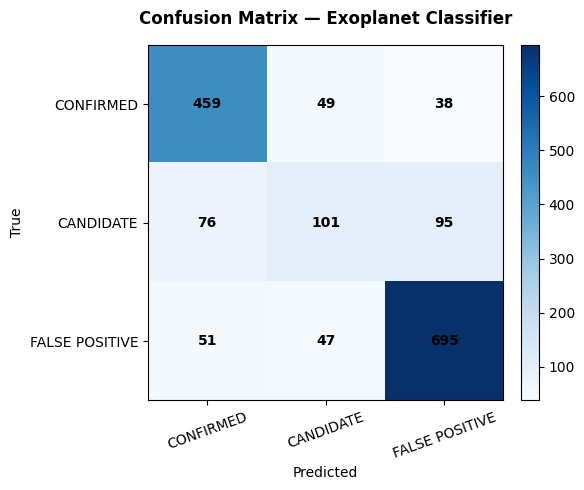

2025-10-15 09:00:06,234 - INFO - 💾 Confusion matrix saved to: /content/drive/MyDrive/exoplanet_mvp/plots/confusion_matrix.png


💾 Confusion matrix saved to: /content/drive/MyDrive/exoplanet_mvp/plots/confusion_matrix.png
🎨 Confusion Matrix plotted successfully!


In [7]:
# === 📊 Colab Cell 6: Confusion Matrix (Matplotlib) ===
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os, logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)

try:
    logging.info("🧠 Generating confusion matrix...")

    # Проверяем, что есть предсказания
    if 'y_pred' not in globals() or 'y_test' not in globals():
        raise ValueError("Predictions or test labels not found. Please run the model training block first.")

    # Матрица ошибок
    labels = ["CONFIRMED", "CANDIDATE", "FALSE POSITIVE"]
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    # Визуализация
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="Blues")
    plt.colorbar(im, fraction=0.046, pad=0.04)

    # Подписи осей
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=20)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title("Confusion Matrix — Exoplanet Classifier", pad=15, fontweight="bold")

    # Добавляем текст в ячейки
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=10, fontweight="bold")

    plt.tight_layout()
    plt.show()

    # === Сохранение графика ===
    PLOTS_DIR = os.path.join(BASE_DIR, "plots")
    os.makedirs(PLOTS_DIR, exist_ok=True)
    plot_path = os.path.join(PLOTS_DIR, "confusion_matrix.png")
    fig.savefig(plot_path, dpi=300)
    logging.info(f"💾 Confusion matrix saved to: {plot_path}")
    print(f"💾 Confusion matrix saved to: {plot_path}")
    print("🎨 Confusion Matrix plotted successfully!")

except Exception as e:
    logging.error(f"❌ Error generating confusion matrix: {e}")
    print(f"❌ Error generating confusion matrix: {e}")


2025-10-15 09:00:06,251 - INFO - 🧠 Extracting feature importances from Random Forest...


🔝 Top 10 most important features:


,feature,importance
3,koi_prad,0.126419
11,koi_ror,0.125561
2,koi_depth,0.106182
0,koi_period,0.101498
5,koi_teq,0.083890
1,koi_duration,0.082003
4,koi_impact,0.078554
9,koi_kepmag,0.069477
10,koi_count,0.063328
8,koi_smet,0.056439


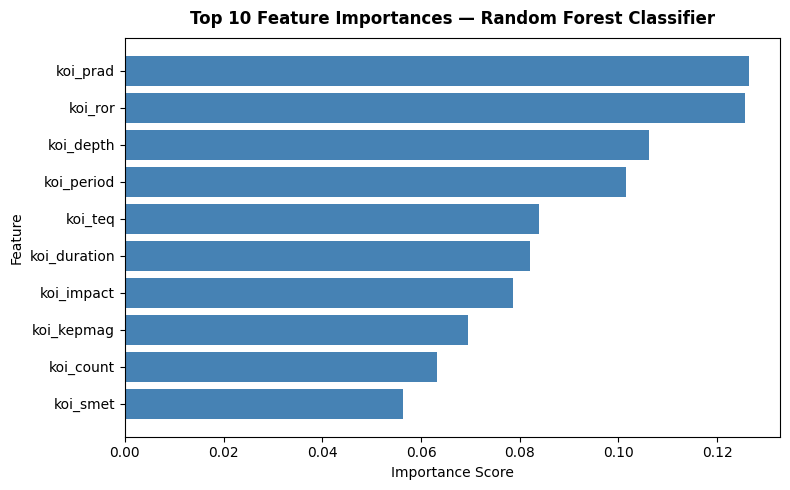

2025-10-15 09:00:07,474 - INFO - 💾 Feature importance plot saved to: /content/drive/MyDrive/exoplanet_mvp/plots/feature_importances.png


💾 Feature importance plot saved to: /content/drive/MyDrive/exoplanet_mvp/plots/feature_importances.png
🎨 Feature importances generated successfully!


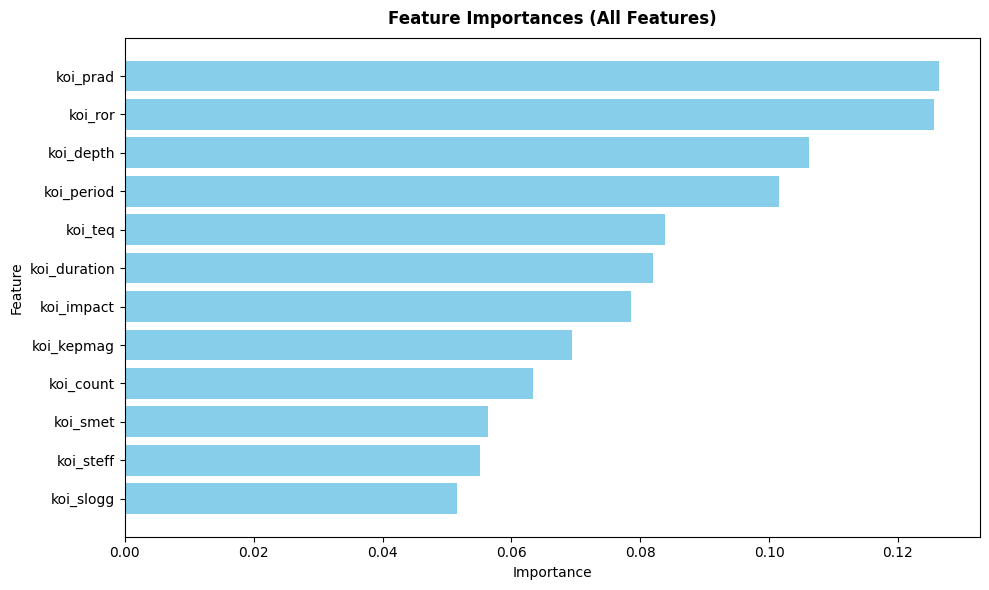

In [8]:
# === 🌟 Colab Cell 7: Feature Importances (matplotlib + table) ===
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)

try:
    logging.info("🧠 Extracting feature importances from Random Forest...")

    # Проверяем, что модель обучена
    if "pipe" not in globals():
        raise ValueError("Pipeline 'pipe' not found. Please train the model first (Cell 5).")

    # Извлекаем RandomForest из пайплайна
    rf_in = pipe.named_steps["model"]

    # Извлекаем важности признаков
    importances = rf_in.feature_importances_
    fi = pd.DataFrame({
        "feature": NUM_FEATURES,
        "importance": importances
    }).sort_values("importance", ascending=False)

    # Вывод таблицы топ-10
    print("🔝 Top 10 most important features:")
    display(fi.head(10))

    # === Визуализация ===
    plt.figure(figsize=(8, 5))
    plt.barh(fi["feature"][:10][::-1], fi["importance"][:10][::-1], color="steelblue")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.title("Top 10 Feature Importances — Random Forest Classifier", pad=10, fontweight="bold")
    plt.tight_layout()
    plt.show()

    # === Сохранение графика ===
    PLOTS_DIR = os.path.join(BASE_DIR, "plots")
    os.makedirs(PLOTS_DIR, exist_ok=True)
    plot_path = os.path.join(PLOTS_DIR, "feature_importances.png")
    plt.figure(figsize=(10, 6))
    plt.barh(fi["feature"][::-1], fi["importance"][::-1], color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Feature Importances (All Features)", pad=10, fontweight="bold")
    plt.tight_layout()
    plt.savefig(plot_path, dpi=300)
    logging.info(f"💾 Feature importance plot saved to: {plot_path}")
    print(f"💾 Feature importance plot saved to: {plot_path}")
    print("🎨 Feature importances generated successfully!")

except Exception as e:
    logging.error(f"❌ Error generating feature importances: {e}")
    print(f"❌ Error generating feature importances: {e}")


In [9]:
# === 🌌 Colab Cell 8: Pretty Probabilities for a Single Example (Plotly) ===
import plotly.graph_objects as go
import numpy as np
import os, logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)

try:
    logging.info("🎯 Generating prediction probability visualization...")

    if "pipe" not in globals():
        raise ValueError("Pipeline 'pipe' not found. Please train the model first.")
    if "X_test" not in globals():
        raise ValueError("Test data 'X_test' not found. Please run the Train/Test Split cell first.")

    CLASS_ORDER = pipe.named_steps["model"].classes_.tolist()

    def plot_probabilities(prob_vector, title="Prediction Probabilities", save=False, save_name="probabilities_example.png"):
        fig = go.Figure(go.Bar(
            x=[p*100 for p in prob_vector],
            y=CLASS_ORDER,
            orientation='h',
            text=[f"{p*100:.1f}%" for p in prob_vector],
            textposition='auto',
            marker=dict(color=['#2ca02c', '#1f77b4', '#d62728'])
        ))
        fig.update_layout(
            title=title,
            xaxis_title="Probability (%)",
            yaxis_title="Class",
            template="plotly_white",
            xaxis=dict(range=[0, 100])
        )
        fig.show()

        if save:
            PLOTS_DIR = os.path.join(BASE_DIR, "plots")
            os.makedirs(PLOTS_DIR, exist_ok=True)
            save_path = os.path.join(PLOTS_DIR, save_name)
            fig.write_image(save_path, scale=2)
            logging.info(f"💾 Probability plot saved to: {save_path}")
            print(f"💾 Probability plot saved to: {save_path}")

    sample_idx = 0
    probs0 = pipe.predict_proba(X_test.iloc[[sample_idx]])[0]
    pred0 = pipe.predict(X_test.iloc[[sample_idx]])[0]

    print(f"🔍 Example #{sample_idx}")
    print(f"Predicted class: {pred0}")
    print(f"Class order: {CLASS_ORDER}")
    plot_probabilities(probs0, title=f"Example #{sample_idx} — Prediction Probabilities", save=True)

    print("🎨 Probability visualization completed successfully!")

except Exception as e:
    logging.error(f"❌ Error generating probability plot: {e}")
    print(f"❌ Error generating probability plot: {e}")


2025-10-15 09:00:07,648 - INFO - 🎯 Generating prediction probability visualization...


🔍 Example #0
Predicted class: CONFIRMED
Class order: ['CANDIDATE', 'CONFIRMED', 'FALSE POSITIVE']


2025-10-15 09:00:10,049 - ERROR - ❌ Error generating probability plot: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



❌ Error generating probability plot: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido



In [10]:
# === 🚀 Colab Cell 9: Quick Tune (Small Randomized Search) ===
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np, os, logging
from IPython.display import HTML, display
import joblib

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)

try:
    logging.info("⚙️ Starting Randomized Search for model tuning...")

    if "pipe" not in globals():
        raise ValueError("Pipeline 'pipe' not found. Please train the model first (Cell 5).")

    # --- 1. Определение параметров для подбора ---
    param_grid = {
        "model__n_estimators": [300, 400, 600, 800],
        "model__max_depth": [None, 12, 16, 22, 28],
        "model__min_samples_split": [2, 4, 6, 8],
        "model__min_samples_leaf": [1, 2, 3, 4],
        "model__max_features": ["sqrt", "log2", None],
    }

    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    # --- 2. Запуск поиска ---
    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_grid,
        n_iter=20,
        scoring="f1_macro",
        n_jobs=-1,
        cv=cv,
        random_state=42,
        verbose=1
    )

    search.fit(X_train, y_train)
    best_pipe = search.best_estimator_

    logging.info("✅ Randomized search completed successfully.")
    print("Best params:", search.best_params_)
    print("CV best f1_macro:", round(search.best_score_, 4))

    # --- 3. Оценка на тестовых данных ---
    y_pred_best = best_pipe.predict(X_test)
    acc_best = accuracy_score(y_test, y_pred_best)
    f1m_best = f1_score(y_test, y_pred_best, average="macro")

    print(f"Test Accuracy (tuned): {acc_best:.4f}")
    print(f"Test Macro F1 (tuned): {f1m_best:.4f}")
    print(classification_report(y_test, y_pred_best, digits=3))

    # --- 4. Сравнение с baseline ---
    if "f1m" in globals() and f1m_best >= f1m:
        pipe = best_pipe
        logging.info("🔥 Using tuned model (improved performance).")
        print(">>> Using tuned model.")
    else:
        logging.info("🧩 Keeping baseline model (tuned version not better).")
        print(">>> Keeping baseline model.")

    # --- 5. Сохранение новой модели ---
    MODEL_DIR = os.path.join(BASE_DIR, "models")
    os.makedirs(MODEL_DIR, exist_ok=True)
    MODEL_TUNED_PATH = os.path.join(MODEL_DIR, "rf_exoplanet_tuned.pkl")
    joblib.dump(best_pipe, MODEL_TUNED_PATH)
    logging.info(f"💾 Tuned model saved to: {MODEL_TUNED_PATH}")

    # --- 6. Красивый вывод NASA-style ---
    acc_percent = acc_best * 100
    f1_percent = f1m_best * 100

    display(HTML(f"""
    <div style='background:#0b0d12; border:2px solid #1e2a38; border-radius:10px;
                 padding:20px; text-align:center; font-family:Orbitron; color:#9ed2ff;'>
      <h2 style='color:#00bfff;'>🚀 Model Evaluation Results (Tuned)</h2>
      <p style='font-size:20px;'>
        ✅ <b>Accuracy:</b> <span style='color:#00ffcc;'>{acc_percent:.2f}%</span><br>
        🧠 <b>Macro F1-score:</b> <span style='color:#ffcc00;'>{f1_percent:.2f}%</span>
      </p>
      <p style='font-size:15px; color:#9ed2ff;'>Model performance after parameter optimization using Randomized Search.</p>
    </div>
    """))

    print("🎯 Model tuning and evaluation completed successfully!")

except Exception as e:
    logging.error(f"❌ Error during model tuning: {e}")
    print(f"❌ Error during model tuning: {e}")


2025-10-15 09:00:10,073 - INFO - ⚙️ Starting Randomized Search for model tuning...


Fitting 4 folds for each of 20 candidates, totalling 80 fits


2025-10-15 09:20:17,180 - INFO - ✅ Randomized search completed successfully.


Best params: {'model__n_estimators': 800, 'model__min_samples_split': 6, 'model__min_samples_leaf': 4, 'model__max_features': None, 'model__max_depth': 28}
CV best f1_macro: 0.7233


2025-10-15 09:20:17,632 - INFO - 🔥 Using tuned model (improved performance).


Test Accuracy (tuned): 0.7741
Test Macro F1 (tuned): 0.7108
                precision    recall  f1-score   support

     CANDIDATE      0.492     0.463     0.477       272
     CONFIRMED      0.790     0.813     0.801       546
FALSE POSITIVE      0.854     0.854     0.854       793

      accuracy                          0.774      1611
     macro avg      0.712     0.710     0.711      1611
  weighted avg      0.771     0.774     0.772      1611

>>> Using tuned model.


2025-10-15 09:20:21,268 - INFO - 💾 Tuned model saved to: /content/drive/MyDrive/exoplanet_mvp/models/rf_exoplanet_tuned.pkl


🎯 Model tuning and evaluation completed successfully!


In [11]:
# === 🌍 Colab Cell 12: Predict Helpers (CSV & Single Form) + Log to Drive ===
from datetime import datetime
import os, pandas as pd, logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s", force=True)

try:
    logging.info("🚀 Initializing prediction utilities...")

    CLASS_ORDER = pipe.named_steps["model"].classes_.tolist()

    # === 1. Helper: check if header needed for logging ===
    def _header_flag(path):
        return not os.path.exists(path)

    # === 2. Predict for a single example ===
    def predict_single(params: dict, log=True):
        """
        params: dict с ключами из NUM_FEATURES (числовые значения)
        return: dict {prediction, prob_<class>...}
        """
        missing = [c for c in NUM_FEATURES if c not in params]
        if missing:
            raise ValueError(f"Missing required parameters: {missing}")

        # 1) Предсказание
        x = pd.DataFrame([params], columns=NUM_FEATURES)
        proba = pipe.predict_proba(x)[0]
        pred  = pipe.predict(x)[0]

        # 2) Результат
        result = {"prediction": pred}
        for cls, p in zip(CLASS_ORDER, proba):
            result[f"prob_{cls.replace(' ', '_')}"] = float(p)

        # 3) Логирование
        if log:
            row = {"timestamp": datetime.utcnow().isoformat()}
            row.update(params)
            row.update(result)
            pd.DataFrame([row]).to_csv(
                NEW_OBS_CSV,
                mode='a',
                header=_header_flag(NEW_OBS_CSV),
                index=False
            )
            logging.info(f"✅ Logged prediction to {NEW_OBS_CSV}")

        return result

    # === 3. Predict for CSV dataset ===
    def predict_csv(csv_path: str, log=True):
        data = pd.read_csv(csv_path)
        missing = [c for c in NUM_FEATURES if c not in data.columns]
        if missing:
            raise ValueError(f"Missing required columns: {missing}")

        proba = pipe.predict_proba(data[NUM_FEATURES])
        preds = pipe.predict(data[NUM_FEATURES])

        out = data.copy()
        out["prediction"] = preds
        for i, cls in enumerate(CLASS_ORDER):
            out[f"prob_{cls.replace(' ', '_')}"] = proba[:, i]
        out.insert(0, "timestamp", datetime.utcnow().isoformat())

        if log:
            out.to_csv(
                NEW_OBS_CSV,
                mode='a',
                header=_header_flag(NEW_OBS_CSV),
                index=False
            )
            logging.info(f"✅ Logged {len(out)} predictions to {NEW_OBS_CSV}")

        return out

    logging.info("🎯 Prediction helpers initialized successfully.")

except Exception as e:
    logging.error(f"❌ Error initializing prediction utilities: {e}")
    print(f"❌ Error initializing prediction utilities: {e}")


2025-10-15 09:20:21,300 - INFO - 🚀 Initializing prediction utilities...
2025-10-15 09:20:21,301 - INFO - 🎯 Prediction helpers initialized successfully.


In [12]:
# === 🚀 NASA Dark Theme Interactive Form v2.2 (Compact + Color-coded + Dual Time) ===
from IPython.display import display, HTML
import ipywidgets as widgets
import plotly.graph_objects as go
from datetime import datetime, timedelta, timezone
import numpy as np

# === Checks ===
if "predict_single" not in globals():
    raise ValueError("❌ Function 'predict_single' not found. Run Cell 12 first.")
if "NUM_FEATURES" not in globals():
    raise ValueError("❌ Variable 'NUM_FEATURES' not found.")
if "CLASS_ORDER" not in globals():
    CLASS_ORDER = pipe.named_steps["model"].classes_.tolist()

# === NASA dark theme ===
display(HTML("""
<style>
body {
  background-color: #0b0d12 !important;
  color: #e0e0e0 !important;
  font-family: 'Orbitron', 'Montserrat', sans-serif;
}
.widget-label {
  color: #9ed2ff !important;
  font-weight: 600;
}
.widget-button {
  border-radius: 10px !important;
  transition: all 0.3s ease-in-out !important;
}
.widget-button:hover {
  box-shadow: 0 0 12px #00bfff !important;
  transform: scale(1.05);
}
.status-bar {
  margin-top: 10px;
  color: #9ed2ff;
  font-size: 12px;
  font-family: 'Montserrat';
}
</style>
<link href="https://fonts.googleapis.com/css2?family=Orbitron:wght@400;600&display=swap" rel="stylesheet">
"""))

# === Tooltips ===
tooltips = {
    "koi_period": "Orbital period (days)",
    "koi_duration": "Transit duration (hours)",
    "koi_depth": "Transit depth (ppm)",
    "koi_prad": "Planet radius (Earth radii)",
    "koi_snr": "Signal-to-noise ratio",
    "koi_impact": "Impact parameter (0=center, 1=edge)",
    "koi_teq": "Equilibrium temperature (Kelvin)",
    "koi_steff": "Stellar effective temperature (Kelvin)",
    "koi_slogg": "Stellar surface gravity (log g)",
    "koi_smet": "Stellar metallicity [Fe/H]",
    "koi_kepmag": "Kepler magnitude (brightness)",
    "koi_count": "Number of observed transits",
    "koi_ror": "Radius ratio (Rp/Rs)"
}

# === 🚀 Compact Probability Visualization ===
def plot_probabilities(probs, title="Prediction Confidence (%)", confidence=None):
    colors = ['#00bfff', '#0affaa', '#ffcc00']
    # динамическая подсветка по уверенности
    if confidence is not None:
        if confidence >= 85:
            bar_color = '#00ff99'
        elif confidence >= 60:
            bar_color = '#ffcc00'
        else:
            bar_color = '#ff6666'
        colors = [bar_color]*3

    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=CLASS_ORDER,
        y=[p * 100 for p in probs],
        marker_color=colors,
        text=[f"{p*100:.1f}%" for p in probs],
        textposition='outside',
        hovertemplate='%{x}: %{y:.2f}%<extra></extra>'
    ))
    fig.add_annotation(
        text="🪐",
        xref="paper", yref="paper", x=0.5, y=1.18,
        showarrow=False, font=dict(size=36)
    )
    fig.update_layout(
        title={'text': f"<b>{title}</b>", 'x': 0.5, 'xanchor': 'center',
               'font': {'color': '#9ed2ff', 'size': 20, 'family': 'Orbitron'}},
        plot_bgcolor='#0b0d12',
        paper_bgcolor='#0b0d12',
        font=dict(color='#e0e0e0', family='Montserrat'),
        xaxis=dict(title='', color='#9ed2ff', showgrid=False),
        yaxis=dict(title='%', color='#9ed2ff',
                   showgrid=True, gridcolor='#1e2a38', range=[0, 100]),
        height=300,
        margin=dict(t=40, b=20, l=40, r=30, pad=0),
        bargap=0.35,
        transition={'duration': 500},
        annotations=[
            dict(
                text="NASA Exoplanet AI Confidence Visualization",
                x=0.5, y=-0.2, xref="paper", yref="paper",
                showarrow=False, font=dict(color="#6fc9ff", size=12, family="Orbitron")
            )
        ]
    )
    fig.show()

# === Input widgets ===
inputs = {}
for feature in NUM_FEATURES:
    tip = tooltips.get(feature, "")
    inputs[feature] = widgets.FloatText(
        value=0.0,
        description=feature,
        tooltip=tip,
        style={'description_width': '150px'},
        layout=widgets.Layout(width="420px")
    )

# === Predict button ===
run_button = widgets.Button(
    description="🚀 Predict Exoplanet Type",
    button_style="",
    layout=widgets.Layout(width="320px", margin="10px 0 5px 0")
)
run_button.style.button_color = '#007bff'
run_button.style.font_weight = 'bold'
output = widgets.Output()
status_bar = widgets.HTML(value="<div class='status-bar'>🛰️ Ready for new prediction...</div>")

# === Helper ===
def interpret_result(pred_class, confidence):
    if confidence >= 85:
        return "🪐 High probability — likely a true exoplanet."
    elif confidence >= 60:
        return "🌗 Medium probability — further observations recommended."
    else:
        return "⚪️ Low probability — likely a false signal or noise."

# === Prediction handler ===
def on_click_run(b):
    with output:
        output.clear_output()
        try:
            params = {f: w.value for f, w in inputs.items()}

            # Validation
            empty_or_zero = [k for k, v in params.items() if v is None or v == 0]
            if empty_or_zero:
                display(HTML(f"""
                <div style='padding:15px; background:#201c1c; border:1px solid #ff5555; border-radius:10px;'>
                  <h4 style='color:#ff7777;'>⚠️ Incomplete or Invalid Input</h4>
                  <p style='font-size:14px; color:#ff9999;'>
                    The following parameters are empty or zero:<br>
                    <b>{", ".join(empty_or_zero)}</b><br>
                    Please fill in all required fields.
                  </p>
                </div>
                """))
                status_bar.value = "<div class='status-bar' style='color:#ff7777;'>⚠️ Fill all required fields before prediction.</div>"
                return

            invalid_neg = [k for k, v in params.items() if v < 0 and k not in ["koi_smet", "koi_kepmag"]]
            if invalid_neg:
                display(HTML(f"""
                <div style='padding:15px; background:#201c1c; border:1px solid #ff5555; border-radius:10px;'>
                  <h4 style='color:#ff7777;'>🚫 Invalid Negative Values</h4>
                  <p style='font-size:14px; color:#ff9999;'>
                    <b>{", ".join(invalid_neg)}</b> must be positive.
                  </p>
                </div>
                """))
                status_bar.value = "<div class='status-bar' style='color:#ff7777;'>⚠️ Invalid negative values detected.</div>"
                return

            # Prediction
            res = predict_single(params, log=True)
            best_class = res["prediction"]
            prob_key = f"prob_{best_class.replace(' ', '_')}"
            confidence = res[prob_key] * 100
            interpretation = interpret_result(best_class, confidence)

            # Dual timezone display
            utc_now = datetime.now(timezone.utc)
            local_time = utc_now + timedelta(hours=5)

            color = "#00ff99" if confidence >= 85 else "#ffcc00" if confidence >= 60 else "#ff6666"

            display(HTML(f"""
            <div style='padding:18px; background:#10131a; border:1px solid #1e2a38;
                        border-radius:12px; box-shadow:0 0 10px {color}40;'>
              <h3 style='color:{color}; font-family:Orbitron;'>🔹 Prediction:
              <span style="color:#9ed2ff;">{best_class}</span></h3>
              <p style='font-size:16px;'>🧠 Confidence:
              <b style="color:{color};">{confidence:.2f}%</b></p>
              <p style='font-size:15px; color:#9ed2ff;'>{interpretation}</p>
              <p style='font-size:12px; color:#6fc9ff;'>
                ⏱️ {utc_now.strftime("%Y-%m-%d %H:%M:%S UTC")}<br>
                🕐 {local_time.strftime("%Y-%m-%d %H:%M:%S (Dushanbe Time)")}
              </p>
            </div>
            """))

            probs = [res[f"prob_{cls.replace(' ', '_')}"] for cls in CLASS_ORDER]
            plot_probabilities(probs, title=f"Prediction Confidence: {confidence:.1f}%", confidence=confidence)
            status_bar.value = f"<div class='status-bar'>✅ Prediction logged at {utc_now.strftime('%H:%M:%S UTC')} / {local_time.strftime('%H:%M:%S Dushanbe')}</div>"

        except Exception as e:
            display(HTML(f"<p style='color:red;'>❌ Error during prediction: {e}</p>"))
            status_bar.value = "<div class='status-bar' style='color:red;'>⚠️ Error occurred.</div>"

# === Display ===
run_button.on_click(on_click_run)
form_items = [inputs[f] for f in NUM_FEATURES] + [run_button, output, status_bar]
display(widgets.VBox(form_items))


/tmp/ipython-input-306163519.py:20: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [13]:
# === 🕒 Colab Cell 13: Enhanced Logging with Dual Timezones ===
from datetime import datetime, timedelta
import os, pandas as pd

def predict_single(params: dict, log=True):
    """
    Predicts exoplanet classification for one observation and logs both UTC and local (Dushanbe) time.
    """
    # 1️⃣ Predict
    x = pd.DataFrame([params], columns=NUM_FEATURES)
    proba = pipe.predict_proba(x)[0]
    pred = pipe.predict(x)[0]

    # 2️⃣ Format result
    result = {"prediction": pred}
    for cls, p in zip(CLASS_ORDER, proba):
        result[f"prob_{cls.replace(' ', '_')}"] = float(p)

    # 3️⃣ Add dual timestamps
    utc_now = datetime.utcnow()
    local_time = utc_now + timedelta(hours=5)

    row = {
        "timestamp_utc": utc_now.strftime("%Y-%m-%d %H:%M:%S"),
        "timestamp_dushanbe": local_time.strftime("%Y-%m-%d %H:%M:%S"),
    }
    row.update(params)
    row.update(result)

    # 4️⃣ Save to CSV log
    if log:
        header = not os.path.exists(NEW_OBS_CSV)
        pd.DataFrame([row]).to_csv(
            NEW_OBS_CSV,
            mode='a',
            header=header,
            index=False
        )

    # 5️⃣ Return structured result
    return result


In [ ]:
# === 🌐 Colab Cell 14: Nova AI Flask Server + ngrok (Fixed for Frontend) ===
!pip install flask flask-cors pyngrok joblib --quiet

from flask import Flask, render_template_string, request
from flask_cors import CORS
from pyngrok import ngrok
import joblib
from datetime import datetime, timedelta
import os

# === Load trained pipeline ===
MODEL_PATH = MODEL_PATH if 'MODEL_PATH' in globals() else "/content/drive/MyDrive/exoplanet_mvp/models/rf_exoplanet_model.pkl"
pipe = joblib.load(MODEL_PATH)
CLASS_ORDER = pipe.named_steps["model"].classes_.tolist()

# === Flask app ===
app = Flask(__name__)
CORS(app)  # ✅ enable CORS for all routes

@app.route("/", methods=["GET"])
def home():
    return "<h2>✅ Nova AI Flask API is running successfully!</h2>"

# === Prediction endpoint for frontend ===
@app.route("/predict", methods=["POST"])
def predict_api():
    try:
        # 1️⃣ Get features from form-data
        features = {f: float(request.form[f]) for f in NUM_FEATURES}

        # 2️⃣ Predict
        res = predict_single(features, log=True)
        prediction = res["prediction"]
        probs = {cls: round(res[f"prob_{cls.replace(' ', '_')}"] * 100, 2) for cls in CLASS_ORDER}

        # 3️⃣ Time info
        utc_now = datetime.utcnow()
        local_now = utc_now + timedelta(hours=5)
        utc_time = utc_now.strftime("%Y-%m-%d %H:%M:%S")
        local_time = local_now.strftime("%Y-%m-%d %H:%M:%S")

        # 4️⃣ Build HTML response for website
        html = f"""
        <h2>🔹 Predicted Class: {prediction}</h2>
        <ul>
            {''.join(f"<li>{cls} — {p}%</li>" for cls, p in probs.items())}
        </ul>
        <div class="footer">
            ⏱️ UTC: {utc_time}<br>🕐 Dushanbe: {local_time}
        </div>
        """
        return html
    except Exception as e:
        return f"<div style='color:red;'>Error: {e}</div>", 500


# === Start ngrok tunnel ===
from pyngrok import ngrok

# Replace YOUR_TOKEN_HERE with your real token from https://dashboard.ngrok.com/get-started/your-authtoken
NGROK_AUTH_TOKEN = "33e1LCWPrHN2YgLUiwuZgkAIFif_7odPQ8jGqBVHq8tmmQ6gK"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok.kill()  # clear previous tunnels
public_url = ngrok.connect(5000)
print(f"🌍 Public API URL: {public_url}")
print("🔗 Use this URL in your HTML like:")
print(f"const API_URL = '{public_url}';")

# === Run Flask ===
app.run(port=5000)


2025-10-15 11:58:20,873 - INFO - Updating authtoken for default "config_path" of "ngrok_path": /root/.config/ngrok/ngrok
2025-10-15 11:58:20,890 - INFO - Opening tunnel named: http-5000-50561d29-cc7a-48e0-99a3-d50e4f6212e3
2025-10-15 11:58:20,908 - INFO - t=2025-10-15T11:58:20+0000 lvl=info msg="no configuration paths supplied"
2025-10-15 11:58:20,911 - INFO - t=2025-10-15T11:58:20+0000 lvl=info msg="using configuration at default config path" path=/root/.config/ngrok/ngrok.yml
2025-10-15 11:58:20,914 - INFO - t=2025-10-15T11:58:20+0000 lvl=info msg="open config file" path=/root/.config/ngrok/ngrok.yml err=nil
2025-10-15 11:58:20,944 - INFO - t=2025-10-15T11:58:20+0000 lvl=info msg="starting web service" obj=web addr=127.0.0.1:4040 allow_hosts=[]
2025-10-15 11:58:21,176 - INFO - t=2025-10-15T11:58:21+0000 lvl=info msg="client session established" obj=tunnels.session
2025-10-15 11:58:21,178 - INFO - t=2025-10-15T11:58:21+0000 lvl=info msg="tunnel session started" obj=tunnels.session
202

🌍 Public API URL: NgrokTunnel: "https://unsplayed-rosaria-flavoressly.ngrok-free.dev" -> "http://localhost:5000"
🔗 Use this URL in your HTML like:
const API_URL = 'NgrokTunnel: "https://unsplayed-rosaria-flavoressly.ngrok-free.dev" -> "http://localhost:5000"';
 * Serving Flask app '__main__'


2025-10-15 11:58:21,342 - INFO - t=2025-10-15T11:58:21+0000 lvl=info msg=end pg=/api/tunnels id=a91303a3e3548ef1 status=201 dur=147.97781ms


 * Debug mode: off


2025-10-15 11:58:21,345 - INFO - WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
2025-10-15 11:58:21,348 - INFO - Press CTRL+C to quit
2025-10-15 11:59:18,366 - INFO - t=2025-10-15T11:59:18+0000 lvl=info msg="join connections" obj=join id=9d7f3ed4b6f5 l=127.0.0.1:5000 r=37.98.158.61:19425
/tmp/ipython-input-306163519.py:20: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/tmp/ipython-input-1837542826.py:37: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

2025-10-15 11:59:18,579 - INFO - 127.0.0.1 - - [15/Oct/2025 11:59:18] "POST /predict HTTP/1.1" 200 -
2025-10-15 12:00:18